In [4]:
import dill
import codecs
import pyautogui
import time
import pyperclip
from pyperiscope import Scope

test = pyautogui.screenshot()

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.patches import Rectangle
%matplotlib widget 

class ClickCollector:
    def __init__(self, pil_image: Image.Image):
        self.coordinates = []
        self.boxes = []
        self.start_point = None
        self.current_box = None
        self.corner_markers = []
        
        img_array = np.array(pil_image)
        # Create figure with tight layout
        self.fig, self.ax = plt.subplots(figsize=(10,10))
        self.fig.tight_layout(pad=0)
        
        # Remove axes and margins
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.ax.set_xmargin(0)
        self.ax.set_ymargin(0)
        
        # Display image without borders
        self.ax.imshow(img_array, extent=(0, img_array.shape[1], img_array.shape[0], 0))
        self.dots, = self.ax.plot([], [], 'ro')
        
        def draw_corners(x, y, w, h):
            for marker in self.corner_markers:
                marker.remove()
            self.corner_markers = []
            
            corners = [(x,y), (x+w,y), (x,y+h), (x+w,y+h)]
            for cx, cy in corners:
                marker, = self.ax.plot(cx, cy, 'rs', markersize=8)
                self.corner_markers.append(marker)
        
        def on_press(event):
            if event.inaxes and event.button == 1 and self.fig.canvas.toolbar.mode == '':
                self.start_point = (event.xdata, event.ydata)
                
                if self.current_box:
                    self.current_box.remove()
                self.current_box = Rectangle(self.start_point, 0, 0, fill=False, color='red', linewidth=2)
                self.ax.add_patch(self.current_box)
        
        def on_motion(event):
            if event.inaxes and self.start_point and self.fig.canvas.toolbar.mode == '':
                width = event.xdata - self.start_point[0]
                height = event.ydata - self.start_point[1]
                self.current_box.set_width(width)
                self.current_box.set_height(height)
                draw_corners(self.start_point[0], self.start_point[1], width, height)
                self.fig.canvas.draw_idle()
        
        def on_release(event):
            if event.inaxes and event.button == 1 and self.start_point:
                if abs(event.xdata - self.start_point[0]) < 3 and abs(event.ydata - self.start_point[1]) < 3:
                    self.coordinates.append(self.start_point)
                    x_coords = [c[0] for c in self.coordinates]
                    y_coords = [c[1] for c in self.coordinates]
                    self.dots.set_data(x_coords, y_coords)
                    if self.current_box:
                        self.current_box.remove()
                    for marker in self.corner_markers:
                        marker.remove()
                    self.corner_markers = []
                else:
                    width = event.xdata - self.start_point[0]
                    height = event.ydata - self.start_point[1]
                    self.boxes.append((
                        self.start_point[0],
                        self.start_point[1],
                        width,
                        height
                    ))
                    draw_corners(self.start_point[0], self.start_point[1], width, height)
                
                self.current_box = None
                self.start_point = None
                self.fig.canvas.draw_idle()
        
        self.fig.canvas.mpl_connect('button_press_event', on_press)
        self.fig.canvas.mpl_connect('motion_notify_event', on_motion)
        self.fig.canvas.mpl_connect('button_release_event', on_release)
        plt.show()
    
    def get_clicks(self):
        return self.coordinates
    
    def get_boxes(self):
        return self.boxes
    
    def clear_all(self):
        self.coordinates = []
        self.boxes = []
        self.dots.set_data([], [])
        for patch in self.ax.patches:
            patch.remove()
        for marker in self.corner_markers:
            marker.remove()
        self.corner_markers = []
        self.fig.canvas.draw_idle()

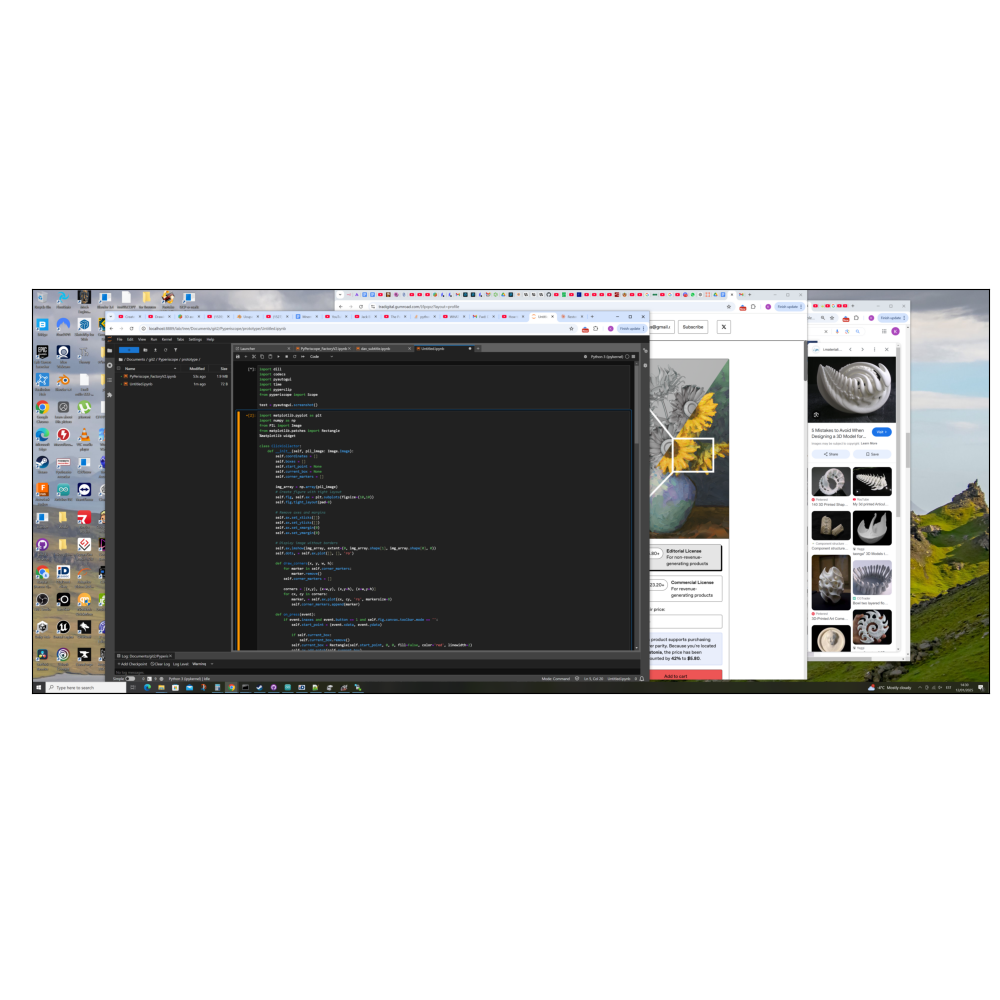

In [6]:
collector = ClickCollector(test)

In [7]:
collector.get_clicks()

[(np.float64(468.14522459751345), np.float64(268.75516014067364))]

In [8]:
collector.get_boxes()

[(np.float64(438.2574439439378),
  np.float64(246.77885083657395),
  np.float64(-40.4364091195435),
  np.float64(95.81670856587482))]

In [ ]:
collector.clear_all()